In [1]:
#https://github.com/pomber/covid19
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

In [2]:
df = pd.read_csv('../data/brazil_corona19_data.csv')
df_estados = pd.read_csv('../data/brazilian_states.csv')
df['date'] = df['date'].astype('datetime64[ns]')

today = str(df.date.max().date())
tomorrow = str(df.date.max().date() + datetime.timedelta(days=1))
yesterday = str(df.date.max().date() - datetime.timedelta(days=1))

df.tail()

,region,state,date,case_day,cases,death_day,deaths,day,%var_case_day,%var_death_day,avg7_cases,avg7_deaths,perc_death,avg7_perc_death
1000,Centro-Oeste,DF,2020-04-15,31,682,0,17,40,138.46,-100.0,24.0,0.0,2.49,2.45
1001,Centro-Oeste,DF,2020-04-16,34,716,3,20,41,9.68,0.0,27.0,1.0,2.79,2.49
1002,Centro-Oeste,DF,2020-04-17,30,746,0,20,42,-11.76,-100.0,27.0,0.0,2.68,2.52
1003,Centro-Oeste,DF,2020-04-18,16,762,4,24,43,-46.67,0.0,26.0,1.0,3.15,2.62
1004,Centro-Oeste,DF,2020-04-19,65,827,0,24,44,306.25,-100.0,30.0,1.0,2.90,2.71


In [3]:
df_brasil = pd.merge(df[df['date']==today], df_estados, how='inner', on=None, left_on='state', 
                 right_on='sigla_estado', left_index=False, right_index=False, sort=False)   

df_brasil = df_brasil[df_brasil['date']==today][['id_estado','avg7_perc_death','avg7_cases','sigla_estado','nome_estado','cases','deaths','perc_death']]
df_brasil['id_estado'] = df_brasil['id_estado'].astype('str')# para fazer o key_on no folium

df_brasil.tail()

,id_estado,avg7_perc_death,avg7_cases,sigla_estado,nome_estado,cases,deaths,perc_death
22,43,1.94,33.0,RS,Rio Grande do Sul,653,16,2.45
23,50,2.09,5.0,MS,Mato Grosso do Sul,101,2,1.98
24,51,1.75,9.0,MT,Mato Grosso,123,3,2.44
25,52,4.48,16.0,GO,Goiás,229,14,6.11
26,53,2.37,20.0,DF,Distrito Federal,614,14,2.28


In [4]:
state_geo = json.load(open('../data/brasil-estados.json'))
for state in state_geo['features']: 
    latLon =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_estados.loc[df_estados['id_estado']==int(codarea),'lat'] = latLon[1]
    df_estados.loc[df_estados['id_estado']==int(codarea),'lon'] = latLon[0]

df_estados.tail()

,id_estado,nome_estado,sigla_estado,id_regiao,nome_regiao,sigla_regiao,lat,lon
22,43,Rio Grande do Sul,RS,4,Sul,S,-29.705809,-53.319974
23,50,Mato Grosso do Sul,MS,5,Centro-Oeste,CO,-20.327475,-54.845564
24,51,Mato Grosso,MT,5,Centro-Oeste,CO,-12.948919,-55.911975
25,52,Goiás,GO,5,Centro-Oeste,CO,-16.042109,-49.623608
26,53,Distrito Federal,DF,5,Centro-Oeste,CO,-15.780746,-47.797341


In [5]:
state_geo = json.load(open('../data/brasil-estados.json'))
m = folium.Map(location=[-15.75, -47.95], zoom_start=4)

# folium.Choropleth(
#     geo_data=state_geo,
#     name='Contaminações',
#     data=df_brasil,
#     columns=['id_estado', 'avg7_cases'],
#     key_on='feature.properties.codarea',
#     fill_color='PuBu',#'YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.3,
#     legend_name='media movel de casos (7 ultimos dias)'
# ).add_to(m)

folium.Choropleth(
    geo_data=state_geo,
    name='Letalidade',
    data=df_brasil,
    columns=['id_estado', 'avg7_perc_death'],
    key_on='feature.properties.codarea',
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= '% letalidade (media movel 7 ultimos dias)'
).add_to(m)

for key,estado in df_estados.iterrows():
    dados = df_brasil[df_brasil['sigla_estado']==estado.sigla_estado]
    detalhes = '<center><b>'+dados.nome_estado.values[0] + ' (' + dados.sigla_estado.values[0] + ')</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.values[0]) + ', mortes: ' + str(dados.deaths.values[0])
    detalhes += ', letalidade: ' + str(dados.perc_death.values[0]) + '%'
#     detalhes = udetalhes
    
    folium.CircleMarker(
        location=[estado.lat,estado.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='#727b7d',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/brazilMap.html')
m

----------------------------
### Brasil - Analysis and monitoring

#### Top 5 deadliest countries + Brazil

In [6]:
cols = ['state', 'date', 'day','case_day', 'cases', 'death_day', 'deaths', 'avg7_cases', 'avg7_deaths','avg7_perc_death', 'perc_death']
df_top_deaths = df[df['date']==today].sort_values('avg7_perc_death', ascending = False)

df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(10)
df_top_deaths

,state,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,PI,2020-12-04,24,3,44,0,7,3.0,0.0,16.30,15.91
2,PB,2020-12-04,25,16,101,2,13,9.0,1.0,12.11,12.87
3,SE,2020-12-04,29,2,44,0,4,1.0,0.0,10.44,9.09
4,PE,2020-12-04,32,144,960,13,85,108.0,9.0,10.26,8.85
5,SP,2020-12-04,47,336,8755,28,588,590.0,44.0,6.53,6.72
6,AL,2020-12-04,36,0,48,0,3,2.0,0.0,6.48,6.25
7,RO,2020-12-04,24,2,35,0,2,3.0,0.0,6.20,5.71
8,RJ,2020-12-04,39,248,2855,15,170,208.0,15.0,5.57,5.95
9,GO,2020-12-04,31,20,229,4,14,16.0,1.0,4.48,6.11
10,AM,2020-12-04,29,156,1206,9,62,112.0,6.0,4.38,5.14


#### Top 5 most transmissible countries + Brazil

In [7]:
df_top_cases = df[df['date']==today].sort_values('avg7_cases', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(10)
df_top_cases

,state,date,day,case_day,cases,death_day,deaths,avg7_cases,avg7_deaths,avg7_perc_death,perc_death
1,SP,2020-12-04,47,336,8755,28,588,590.0,44.0,6.53,6.72
2,RJ,2020-12-04,39,248,2855,15,170,208.0,15.0,5.57,5.95
3,CE,2020-12-04,27,94,1676,7,74,121.0,6.0,3.65,4.42
4,AM,2020-12-04,29,156,1206,9,62,112.0,6.0,4.38,5.14
5,PE,2020-12-04,32,144,960,13,85,108.0,9.0,10.26,8.85
6,SC,2020-12-04,31,36,768,3,24,58.0,2.0,2.93,3.12
7,MG,2020-12-04,36,56,806,3,20,44.0,2.0,2.21,2.48
8,MA,2020-12-04,23,54,398,3,24,43.0,3.0,4.37,6.03
9,PR,2020-12-04,32,62,738,4,30,42.0,3.0,3.42,4.07
10,BA,2020-12-04,38,38,673,0,21,38.0,1.0,2.99,3.12


#### Brazilian states to be analised

#### Cases and deaths 

In [8]:
#inform the countries you want to analise
monitoredStates = df_top_deaths['state'].head(10).to_numpy()
monitoredStates

array(['PI', 'PB', 'SE', 'PE', 'SP', 'AL', 'RO', 'RJ', 'GO', 'AM'],
      dtype=object)

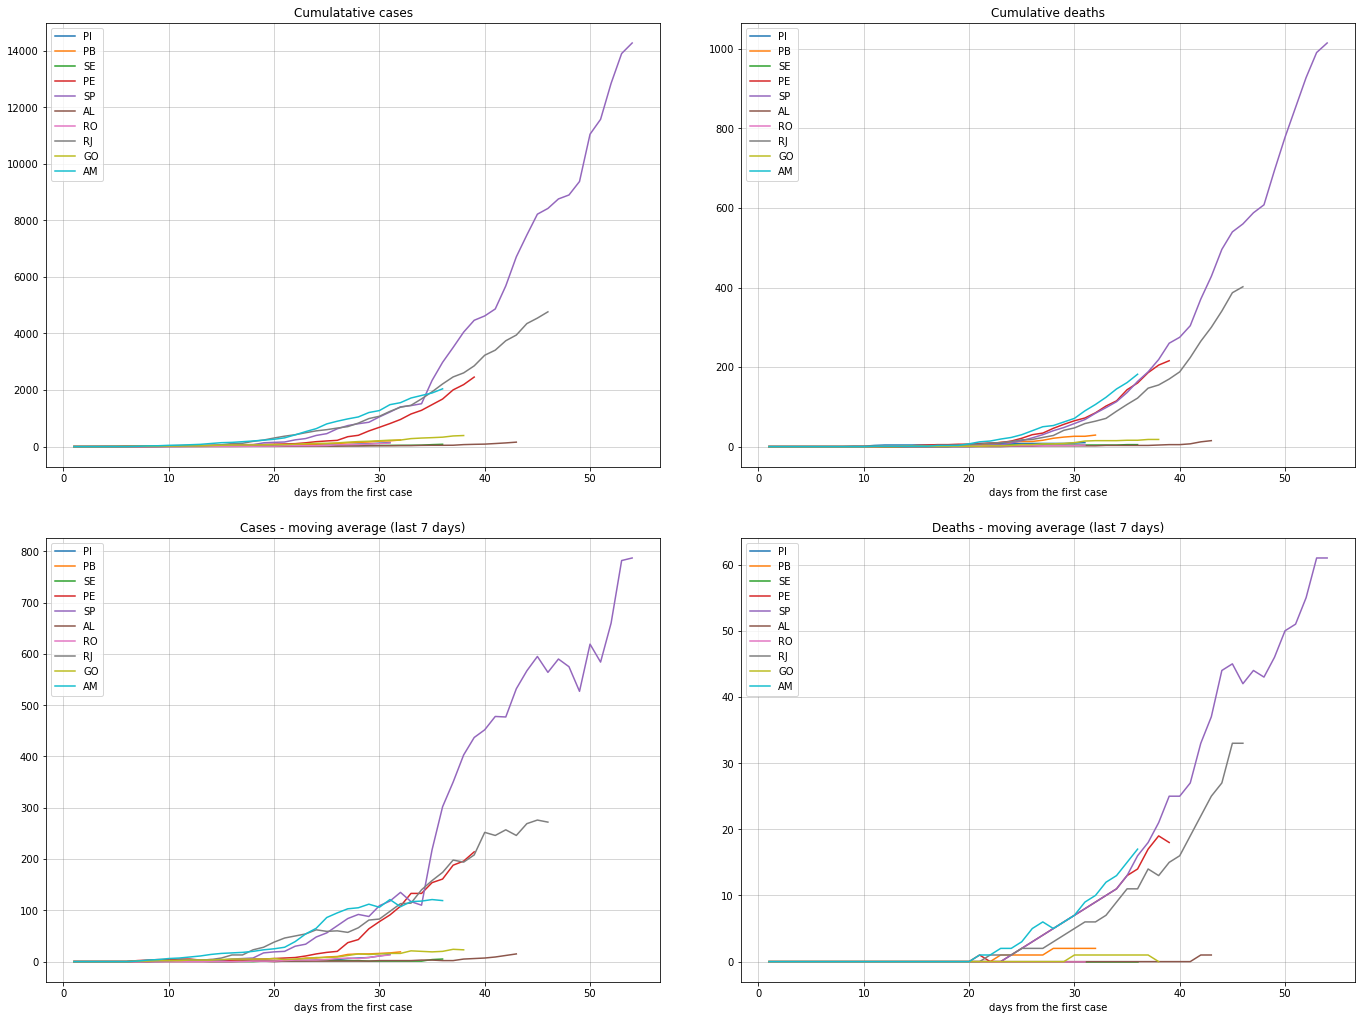

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Cumulative deaths")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cases - moving average (last 7 days)")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Deaths - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    ax1.plot(df[df['state'] == state].day, df[df['state'] == state].cases, label = state)
    ax2.plot(df[df['state'] == state].day, df[df['state'] == state].deaths, label = state)
    ax3.plot(df[df['state'] == state].day, df[df['state'] == state].avg7_cases, label = state)
    ax4.plot(df[df['state'] == state].day, df[df['state'] == state].avg7_deaths, label = state)
#     ax1.plot(df[df['country'] == country].day, df[df['country'] == country].cases, label = country)
#     ax2.plot(df[df['country'] == country].day, df[df['country'] == country].deaths, label = country)
#     ax3.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_cases, label = country)
#     ax4.plot(df[df['country'] == country].day, df[df['country'] == country].avg7_deaths, label = country)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.savefig('../analysis/brazilian_states_cases_deaths.png')

### Generating the markdown file

In [10]:
f = open('../analysis/README.md', 'w')

readme = '[<img src="https://raw.githubusercontent.com/NovelCOVID/API/master/assets/flags/gb.png" width="30"  /> English version](README_EN.md)'
readme += '\n\n# **Análises e monitoramento**\n'

readme += '\n### Letalidade dos estados brasileiros\n'
readme += 'O nível de letalidade demonstrado no mapa é definido a partir da média móvel dos últimos 7 dias da letalidade de cada estado.\n'
readme += '<img src="brazilMap.png" width="100%"  />'
# readme += '[![Clique aqui para o mapa atualizado](brazilMap.png)](brazilMap.html)'

readme += '\n\nEstas análises são relativas aos dados da pandemia Covid19 no Brasil até a data de **' + today + '**.\n\n'
readme += 'Como existem muitos estados, colocar em um único gráfico todos seus dados tornaria a leitura e compreensão inviáveis, desta forma, foram selecionados os 10 mais mortais:'
readme += str(monitoredStates) + '.\n\n'
readme += '\n***Dica**: você pode alterar você mesmo neste notebook quais estados você prefere comparar.*\n\n'
readme += '## Top 10 estados mais letais do Brasil\n'
readme += df_top_deaths.to_markdown()
# readme += tabulate(df_top_deaths.values,df_top_deaths.columns, tablefmt="pipe")
readme += '\n\n\n ## Top 10 estados mais transmissíveis do Brasil\n'
readme += df_top_cases.to_markdown()
#tabulate(df_top_cases.values,df_top_cases.columns, tablefmt="pipe")

readme += '\n----------------------\n'
readme += '## Casos e mortes\n'
readme += '![](brazilian_states_cases_deaths.png)'

readme += '\n\n [Comparativos do Brasil com outro países do mundo podem ser encontratos aqui.](README_WORLD.md#an%C3%A1lises-do-brasil)'


f.write(readme)
f.close()

###########################################

f = open('../analysis/README_EN.md', 'w')
readme = '[<img src="https://raw.githubusercontent.com/NovelCOVID/API/master/assets/flags/br.png" width="30"  /> Versão em português](README_WORLD.md)'

readme += '\n\n# **Analysis and monitoring**\n'

readme += '\n### Lethality of the brazilian states\n'
readme += 'The lethality level shown in this map is defined from the moving average of the last 7 days of each state lethality.\n'
readme += '<img src="brazilMap.png" width="100%"  />'
# readme += '[![Click here for updated map](brazilMap.png)](brazilMap.html)'

readme += '\n\nThese analysis are related to Brazil Convid19 pandemic data up to **' + today + '**.\n\n'
readme += 'As there are too many states to have their data plotted together, were selected the 10 deadliest:'
readme += str(monitoredStates) + '.\n\n'
readme += '\n***Tip**: you can yourself select in this notebook which states you prefer to compare.*\n\n'
readme += '## Top 10 deadliest states of Brazil\n'
readme += df_top_deaths.to_markdown()
# readme += tabulate(df_top_deaths.values,df_top_deaths.columns, tablefmt="pipe")
readme += '\n\n\n ## Top 10 most transmissible states of Brazil\n'
readme += df_top_cases.to_markdown()
#tabulate(df_top_cases.values,df_top_cases.columns, tablefmt="pipe")

readme += '\n----------------------\n'
readme += '## Cases and deaths\n'
readme += '![](brazilian_states_cases_deaths.png)'

readme += '\n\n [Comparison of Brazil and among some other contries around the world can be found here.](README_WORLD_EN.md#brazils-analysis)'
f.write(readme)
f.close()
print('Brazilian analysis done!')

Brazilian analysis done!
